In [0]:
#

# Colab Setup

In [1]:
# set tensorflow version
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.2.0-rc3'

In [2]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# copy the script file to current folder so it can be imported.
import shutil
import os
original = [
  r'/content/drive/My Drive/time_sequence_alchemy/utils/data_prep.py',
  r'/content/drive/My Drive/time_sequence_alchemy/utils/model.py',
  r'/content/drive/My Drive/time_sequence_alchemy/utils/others.py',
  r'/content/drive/My Drive/time_sequence_alchemy/log_embeddings_16_sg.txt',
]
target = [
  r'./utils/data_prep.py',
  r'./utils/model.py',
  r'./utils/others.py',
  r'./log_embeddings_16_sg.txt',
]

if not os.path.exists('./utils'):
  os.makedirs('./utils')

for orig, targ in zip(original, target):
  shutil.copyfile(orig, targ)
  print('Script copied:', targ)


Script copied: ./utils/data_prep.py
Script copied: ./utils/model.py
Script copied: ./utils/others.py
Script copied: ./log_embeddings_16_sg.txt


In [0]:
# data file on Colab
data_fn = r'/content/drive/My Drive/time_sequence_alchemy/data/HDFS/Xy_dataset_120s.pkl'
data_fn = r'/content/drive/My Drive/time_sequence_alchemy/data/HDFS/Xy_dataset.pkl'

In [0]:
from utils.data_prep import tokenize, trim_time_sequence, pad_time_sequence, prepare_dataset
from utils.model import TimeChanger_FFT, TimeChangerLstm, TimeChanger, naive_evaluate
from utils.model import load_embeddings
from utils.others import print_train_info_v2, plot_and_save
import tensorflow as tf
import numpy as np
import pickle
from time import time

# Load Data

In [6]:
# Load data
print('\nLoading data...', end='')
start = time()
with open(data_fn,'rb') as f:
  X, y = pickle.load(f)
print('{:.2f}s\n'.format(time()-start))

# separate value & timestamp
print('\nProcessing data...', end='')
start = time()
x_seq =  X[:, 0]
x_ts = X[:, 1].copy()
# y = y[0:5000]
del X

# tokenization
x_tok, tokenizer = tokenize(x_seq)  # 48 tokens
vocab_size = len(tokenizer.word_counts)
# trim data to a certain time length
trim_time_sequence(x_tok, x_ts, 100)  # seconds, maybe 120?
# front pad data to form matrices.
x_tok, x_ts = pad_time_sequence(x_tok, x_ts, 
    maxlen=250, ts_interval=0.1)

print('{:.2f}s\n'.format(time()-start))


Loading data...28.93s


Processing data...139.67s



## Load embeddings
Load the word2vec results. For token 0 (placeholder), set embedding to all 0.

In [7]:
embeddings, embedding_dims = load_embeddings('./log_embeddings_16_sg.txt')
# obtain token - embedding matrix, token zero's embedding is zero.
embedding_matrix = np.zeros((vocab_size+1, embedding_dims))

for word, i in tokenizer.word_index.items():
    embedding_matrix[i] = embeddings[word]

print(embedding_matrix.shape)

vocab_size, embedding_dims: 48 16
(49, 16)


In [0]:
# make dataset
test_ratio = 0.2
val_ratio = 0.2
train_dataset, val_dataset, test_dataset = prepare_dataset(x_tok, x_ts, y,
            test_ratio=test_ratio, val_ratio=val_ratio, batch_size=256)
total_size = sum(y) * 2
val_size = int(total_size * val_ratio)
train_size = int(total_size * (1 - test_ratio - val_ratio))

In [0]:
# make dataset
test_ratio = 0.4
train_dataset, test_dataset = prepare_dataset(x_tok, x_ts, y,
                  test_ratio=test_ratio, batch_size=256)
total_size = sum(y) * 2
train_size = int(total_size * (1 - test_ratio))

In [12]:
# check dataset
for _x, _ts, _y in train_dataset:
  print(_y[0:20].numpy())
  break
for _x, _ts, _y in val_dataset:
  print(_y[0:20].numpy())
  break
for _x, _ts, _y in test_dataset:
  print(_y[0:20].numpy())
  break

[0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1]
[1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0]
[1 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0]


# Model & Training

## Full RNN model

In [44]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(
    vocab_size+1, embedding_dims,    # +1 because of padding 0
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False, input_length=250),  # input_length=input_length
  tf.keras.layers.LSTM(units=64, return_sequences=True),
  tf.keras.layers.LSTM(units=32, return_sequences=False),
  tf.keras.layers.Dense(units=32, activation='sigmoid'),
  tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

model.summary()
# define metrics, to display during training
train_loss = tf.keras.metrics.Mean()
train_metrics = {
    'accuracy': tf.keras.metrics.BinaryAccuracy(),
    'precision': tf.keras.metrics.Precision(),
    'recall': tf.keras.metrics.Recall(),
    }
val_metrics = {
    'loss': tf.keras.metrics.Mean(),
    'accuracy': tf.keras.metrics.BinaryAccuracy(),
    }
# training history and curve
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

# define other training parameters
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)   #Adam, SGD
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 250, 16)           784       
_________________________________________________________________
lstm_12 (LSTM)               (None, 250, 64)           20736     
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 35,025
Trainable params: 34,241
Non-trainable params: 784
_________________________________________________________________


In [48]:
# start training
print('Start training with {} samples, validate with {} samples'.format(train_size, val_size))
epochs = 1000   # will run 3 hours worst case.
for epoch in range(epochs):
  start = time()
  
  # reset metrics
  train_loss.reset_states()
  for metric in train_metrics.values():
    metric.reset_states()
  for metric in val_metrics.values():
    metric.reset_states()

  for x_batch, ts_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:     # watch_accessed_variables=False
      y_pred = model(x_batch)  # ((x_batch, ts_batch))
      y_pred = tf.squeeze(y_pred, 1)   # make it same dimension as y

      # Loss value for this minibatch
      loss = loss_fn(y_batch, y_pred)
      loss += sum(model.losses)  # must have, what does this do?
      
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # update metrics
    train_loss.update_state(loss)
    for metric in train_metrics.values():
        metric.update_state(y_batch, y_pred)
    # print('~', end='')
  
  # update val metrics
  for x_batch, ts_batch, y_batch in val_dataset:
    y_val_pred = model(x_batch)
    y_val_pred = tf.squeeze(y_val_pred, 1)
    loss = loss_fn(y_batch, y_val_pred)
    val_metrics['loss'].update_state(loss)
    val_metrics['accuracy'].update_state(y_batch, y_val_pred)

  # log 
  history['train_loss'].append(train_loss.result().numpy())
  history['train_acc'].append(train_metrics['accuracy'].result().numpy())
  history['val_loss'].append(val_metrics['loss'].result().numpy())
  history['val_acc'].append(val_metrics['accuracy'].result().numpy())

  print_train_info_v2(epoch, time()-start, history)

  # determine early stopping
  # sometimes the loss goes up for a short period, do nothing and wait.
  # stops only when it's absolutely flat.
  
  w = 5     # early stopping moving average window
  n = 5     # early stopping hesitate epochs
  thres = 0.00015        # loss difference threshold
  acc_thres = 0.7   # absolute loss threshold

  if epoch >= n+w+1:
    # loss moving average of the last few epochs
    loss_MA = [history['val_loss'][i-w:i] for i in range(epoch-n, epoch+1)]
    loss_MA = [sum(values) / w for values in loss_MA]
    acc_MA = [history['val_acc'][i-w:i] for i in range(epoch-n, epoch+1)]
    acc_MA = [sum(values) / w for values in acc_MA]
    # for the last n losses, must be going down, and diff < thres
    train_stopping = [abs(a-b)<=thres for (a,b) in zip(loss_MA[0:-1], loss_MA[1:])]
    if sum(train_stopping) == n and acc_MA[-1] >= acc_thres:
      print('Early stopping triggered.')
      print_train_info(epoch, time()-start, train_loss, train_metrics)
      break
  
  # save weights every epoch
  if epoch % 10 == 0: model.save_weights('./checkpoints/my_checkpoint')

Start training with 20205 samples, validate with 6735 samples
epoch 0 - 6s. train_loss: 0.5886 train_acc: 77.87% val_loss: 0.5890 val_acc: 77.18% 
epoch 1 - 6s. train_loss: 0.5895 train_acc: 77.65% val_loss: 0.5921 val_acc: 76.46% 
epoch 2 - 6s. train_loss: 0.5897 train_acc: 77.69% val_loss: 0.5874 val_acc: 77.58% 
epoch 3 - 6s. train_loss: 0.5871 train_acc: 78.42% val_loss: 0.5820 val_acc: 79.13% 
epoch 4 - 6s. train_loss: 0.5921 train_acc: 77.67% val_loss: 0.5862 val_acc: 77.95% 
epoch 5 - 6s. train_loss: 0.5885 train_acc: 78.04% val_loss: 0.5831 val_acc: 78.70% 
epoch 6 - 5s. train_loss: 0.5879 train_acc: 78.14% val_loss: 0.5836 val_acc: 78.67% 
epoch 7 - 6s. train_loss: 0.5884 train_acc: 78.09% val_loss: 0.5834 val_acc: 78.73% 
epoch 8 - 6s. train_loss: 0.5898 train_acc: 77.51% val_loss: 0.5880 val_acc: 77.44% 
epoch 9 - 6s. train_loss: 0.5914 train_acc: 77.23% val_loss: 0.5826 val_acc: 78.92% 
epoch 10 - 6s. train_loss: 0.5872 train_acc: 78.20% val_loss: 0.5846 val_acc: 78.36% 
ep

KeyboardInterrupt: ignored

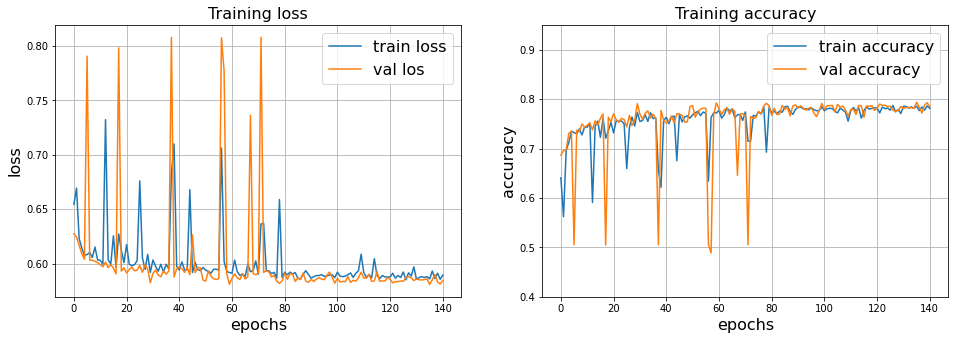

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.legend(['train loss', 'val los'], fontsize=16)
plt.xlabel('epochs', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.title('Training loss', fontsize=16)
# plt.ylim((0.57,0.7))
plt.grid()

plt.subplot(1,2,2)
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.legend(['train accuracy', 'val accuracy'], fontsize=16)
plt.xlabel('epochs', fontsize=16)
plt.ylabel('accuracy', fontsize=16)
plt.title('Training accuracy', fontsize=16)
plt.ylim((0.4,0.95))
plt.grid()

In [50]:
print('Evaluation on train dataset:')
(tr_acc, tr_p, tr_r) = naive_evaluate(model, train_dataset)

print('Evaluation on test dataset:')
(te_acc, te_p, te_r) = naive_evaluate(model, test_dataset)

print('\nFor logging: epochs, tr_loss, te_acc, te_p, te_r, te_acc, te_p, te_r')
print(len(history['train_loss']), history['train_loss'][-1],tr_acc, tr_p, tr_r, te_acc, te_p, te_r)

Evaluation on train dataset:
Acc: 78.36%, P: 98.11%, R: 57.92%
Evaluation on test dataset:
Acc: 79.27%, P: 97.95%, R: 57.87%

For logging: epochs, tr_loss, te_acc, te_p, te_r, te_acc, te_p, te_r
141 0.5892609 0.78358734 0.9810847 0.5791502 0.79265046 0.9794977 0.5787402


### check results

In [18]:
# reconstruct test data
x_test = []
ts_test = []
y_test = []
for x_batch, ts_batch, y_batch in test_dataset:
  x_test.append(x_batch)
  ts_test.append(ts_batch)
  y_test.append(y_batch)
x_test = np.concatenate(x_test)
ts_test = np.concatenate(ts_test)
y_test = np.concatenate(y_test)

x_test.shape, y_test.shape

((6736, 250), (6736,))

In [19]:
# confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict_classes(x_test)
result = [a==b for a,b in zip(y_pred, y_test)]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [20]:
confusion_matrix(y_test, y_pred)

array([[3402,   32],
       [1781, 1521]])

too many faulty labels are considered healty.

Find the error prediction with regard to length.

In [0]:
err_cnt_by_len = [0] * 251
cor_cnt_by_len = [0] * 251
for _x, _r in zip(x_test, result):
  if _x[0] != 0: length=250
  else: length = np.where(_x[::-1]==0)[0][0]
  err_cnt_by_len[length] += int(~_r)
  cor_cnt_by_len[length] += int(_r)

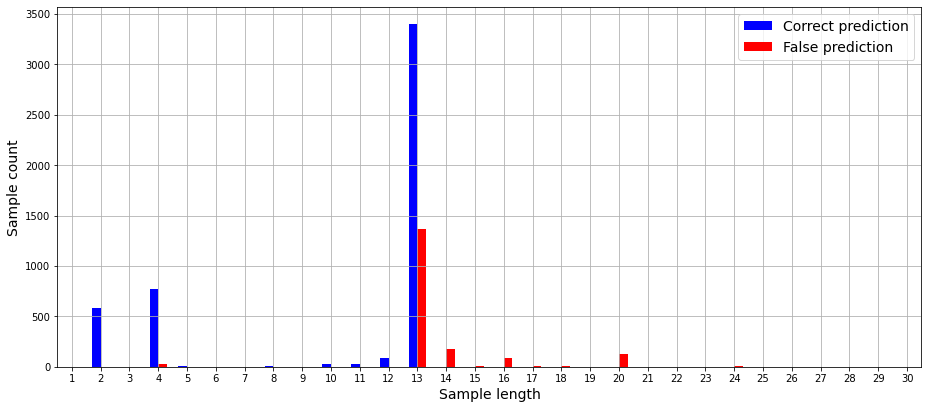

In [22]:
X = np.arange(251)
fig = plt.figure(figsize=(12,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(X-0.15, cor_cnt_by_len, color = 'b', width = 0.3)
ax.bar(X+0.15, err_cnt_by_len, color = 'r', width = 0.3)
ax.set_xticks(np.arange(0,51))
ax.set_xlim(0.5,30.5)
ax.legend(['Correct prediction', 'False prediction'], fontsize=14)
ax.set_xlabel('Sample length', fontsize=14)
ax.set_ylabel('Sample count', fontsize=14)
ax.grid()

In [0]:
# examine false predictions' probability
y_prob = model.predict(x_test)
print('False predictions:')
for _y, _true, _r in zip(y_prob, y_test, result):
  if _r == False:
    print('Truth {}, prediction: {:.4f}'.format(_true, _y[0]))

examine a few samples.

In [0]:
for _x, _r in zip(x_test, result):
  if _x[0] != 0: length=250
  else: length = np.where(_x[::-1]==0)[0][0]
  if length==13 and ~_r: break

In [0]:
_x[-13:]

array([7, 1, 1, 1, 2, 2, 2, 3, 4, 3, 4, 3, 4], dtype=int32)

In [0]:
_x[-13:]

array([1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2], dtype=int32)

## Full CNN model

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(
    vocab_size+1, embedding_dims,    # +1 because of padding 0
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False, input_length=250),  # input_length=input_length
  tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=3),
  tf.keras.layers.MaxPool1D(pool_size=2),
  tf.keras.layers.Conv1D(filters=64, kernel_size=4, strides=3),
  tf.keras.layers.GlobalMaxPool1D(),
  tf.keras.layers.Dense(units=32, activation='relu'),
  tf.keras.layers.Dense(units=32, activation='relu'),
  tf.keras.layers.Dense(units=1, activation='sigmoid'),
])
model.summary()

# define metrics, to display during training
train_loss = tf.keras.metrics.Mean()
train_acc = tf.keras.metrics.BinaryAccuracy()
metrics = {
    'accuracy': tf.keras.metrics.BinaryAccuracy(),
    'precision': tf.keras.metrics.Precision(),
    'recall': tf.keras.metrics.Recall(),
    }

# training history and curve
history = {'loss':[], 'accuracy':[]}

# define other training parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)   #Adam, SGD
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 250, 16)           784       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 83, 32)            2080      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 41, 32)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 13, 64)            8256      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 32)               

In [0]:
rs = naive_evaluate(model, test_dataset)

Acc: 77.46%, P: 98.16%, R: 55.61%


In [0]:
rs

(0.7745643, 0.981608, 0.5561179)

In [0]:
def naive_evaluate(model, dataset):
    metrics = {
        'accuracy': tf.keras.metrics.BinaryAccuracy(),
        'precision': tf.keras.metrics.Precision(),
        'recall': tf.keras.metrics.Recall(),
        }
    for x_batch, ts_batch, y_batch in dataset:
        y_pred = model((x_batch, ts_batch))
        y_pred = tf.squeeze(y_pred, 1)
    
        for metric in metrics.values():
            metric.update_state(y_batch, y_pred)

    acc = metrics['accuracy'].result().numpy()
    p = metrics['precision'].result().numpy()
    r = metrics['recall'].result().numpy()
    print('Acc: {:.2%}, P: {:.2%}, R: {:.2%}'.format(acc, p, r))
    
    return (acc, p, r)

In [0]:
print('Evaluation on test dataset:')
naive_evaluate(model, test_dataset)

Evaluation on test dataset:
Acc: 73.88%, P: 93.51%, R: 51.27%


In [0]:
# obtain token - embedding matrix, token zero's embedding is zero.
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in tokenizer_obj.word_index.items():
    embedding_matrix[i] = embeddings[word]

print(embedding_matrix.shape)

In [0]:
tf.keras.layers.Embedding(
        vocab_size, EMBEDDING_DIM,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        input_length=max_length,
        trainable=False),
 

# New Model

In [0]:
class TimeChangerLstm(tf.keras.Model):
    def __init__(self, vocab_size, embedding_matrix=None):
        super().__init__()
        
        embedding_dims = 16
        max_duration = 100 # seconds
        resolution = 0.1   # seconds
        self.embed = tf.keras.layers.Embedding(
            vocab_size+1, embedding_dims,    # +1 because of padding 0
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable=False)  # input_length=input_length

        self.resample = ResampleLayer(max_duration, resolution)
        self.conv1d = tf.keras.layers.Conv1D(filters=32, kernel_size=8, strides=3)  # input_shape=(None,21,1)
        self.lstm1 = tf.keras.layers.LSTM(units=32, dropout=0.0, return_sequences=True)
        self.lstm2 = tf.keras.layers.LSTM(units=32, dropout=0.0, return_sequences=False)
        #self.lstm3 = tf.keras.layers.LSTM(units=32, dropout=0.0)
        # self.pool1d = tf.keras.layers.GlobalMaxPool1D()
        self.fc1 = tf.keras.layers.Dense(units=32, activation='tanh')  # input_shape=input_shape
        #self.fc2 = tf.keras.layers.Dense(units=32, activation='tanh')
        self.final = tf.keras.layers.Dense(units=1, activation='sigmoid')
        
    #@tf.function
    def call(self, data):
        
        in_seq, ts_seq = data
        in_seq = self.embed(in_seq)
        output = self.resample((in_seq, ts_seq))
        output = self.conv1d(output)
        output = self.lstm1(output)
        output = self.lstm2(output)
        #output = self.lstm3(output)
        output = self.fc1(output)
        #output = self.fc2(output)
        output = self.final(output)
        return output